## **5G-Energy consumption model**

In this checkpoint, you are to work on the '5G-Energy consumption' dataset that was provided by the  international telecommunication union (ITU) in 2023 as part of a global challenge for data scientists all over the world.

#### **Checkpoint problematic:**
Network Operational Expenditure (OPEX) already accounts for around 25% of the total telecom operator’s cost, and 90% of it is spent on large energy bills.
And, more than 70% of this energy is estimated to be consumed by the Radio Access Network (RAN), particularly by the Base Stations (BSs).

Thus, **the objective of this checkpoint is to build and train a ML model to estimate the energy consumed by different 5G base stations** taking into consideration the impact of various engineering configurations, traffic conditions, and energy-saving methods.

In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
# Loading Dataset
df = pd.read_csv("5G_energy_consumption_dataset.csv")

In [ ]:
# Basic Dataset Information
print("Dataset Info:")
df.info()  # Overview of data types and non-null counts

print("\nMissing Values:\n", df.isnull().sum())  # To count of missing values per column
print("\nDuplicate Rows:", df.duplicated().sum())  # Number of duplicate records

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92629 entries, 0 to 92628
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     92629 non-null  object 
 1   BS       92629 non-null  object 
 2   Energy   92629 non-null  float64
 3   load     92629 non-null  float64
 4   ESMODE   92629 non-null  float64
 5   TXpower  92629 non-null  float64
dtypes: float64(4), object(2)
memory usage: 4.2+ MB

Missing Values:
 Time       0
BS         0
Energy     0
load       0
ESMODE     0
TXpower    0
dtype: int64

Duplicate Rows: 0


In [ ]:
# Convert 'Time' Column to DateTime Format
df['Time'] = pd.to_datetime(df['Time'], format='%Y%m%d %H%M%S')
df['Day'] = df['Time'].dt.day

df['Hour'] = df['Time'].dt.hour  # To extract useful time features

In [ ]:
# Handling Missing Values
df = df.dropna()  # Simple removal; could also use imputation for larger datasets

# Removing Duplicates
df = df.drop_duplicates()

In [ ]:
# Encoding Categorical Feature 'BS' Using Label Encoding
le = LabelEncoder()
df['BS_encoded'] = le.fit_transform(df['BS'])

In [ ]:
# Outlier Detection and Removal (IQR Method)
outlier_columns = ['Load', 'TXpower', 'Energy']
for col in outlier_columns:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]  # To filter out outliers

In [ ]:
# Correlation Heatmap to Visualize Feature Relationships
selected_columns = ['Energy', 'Load', 'TXpower', 'BS_encoded', 'Hour', 'Day']
missing_cols = [col for col in selected_columns if col not in df.columns]
if missing_cols:
    print(f"\nSkipping heatmap: missing columns {missing_cols}")
else:
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[selected_columns].corr(), annot=True, cmap='viridis')
    plt.title('Correlation Matrix')
    plt.show()


Skipping heatmap: missing columns ['Load']


In [ ]:
# Selecting Features and Target Variable
feature_columns = ['Load', 'TXpower', 'BS_encoded', 'Hour', 'Day']
available_features = [col for col in feature_columns if col in df.columns]

if not available_features:
    raise KeyError("None of the specified feature columns are available in the DataFrame.")

print("Using features:", available_features)
X = df[available_features]  # Independent variables
y = df['Energy'] if 'Energy' in df.columns else None
if y is None:
    raise KeyError("Target variable 'Energy' not found in the DataFrame.")

Using features: ['TXpower', 'BS_encoded', 'Hour', 'Day']


In [ ]:
# Spliting Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Helper Function to Evaluate Models
def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name}:")
    print("MAE:", mean_absolute_error(y_test, y_pred))  # Mean Absolute Error
    print("MSE:", mean_squared_error(y_test, y_pred))  # Mean Squared Error
    print("R^2 Score:", r2_score(y_test, y_pred))       # Coefficient of Determination

In [ ]:
# Training and Evaluating Linear Regression Model
evaluate_model(LinearRegression(), "Linear Regression")


Linear Regression:
MAE: 8.47286465781725
MSE: 115.18371197156736
R^2 Score: 0.2506080298384943


In [ ]:
# Training and Evaluating Decision Tree Regressor
evaluate_model(DecisionTreeRegressor(random_state=42), "Decision Tree Regressor")


Decision Tree Regressor:
MAE: 1.3955108691363711
MSE: 5.504346070825276
R^2 Score: 0.9641884023716416


In [ ]:
# Training and Evaluating Gradient Boosting Regressor
evaluate_model(GradientBoostingRegressor(random_state=42), "Gradient Boosting Regressor")


Gradient Boosting Regressor:
MAE: 5.444524828601748
MSE: 48.246509031455666
R^2 Score: 0.6861053890551618


In [ ]:
# Training and Evaluating XGBoost Regressor
evaluate_model(XGBRegressor(random_state=42), "XGBoost Regressor")


XGBoost Regressor:
MAE: 3.4537475868500795
MSE: 24.048537085227597
R^2 Score: 0.8435388105025705


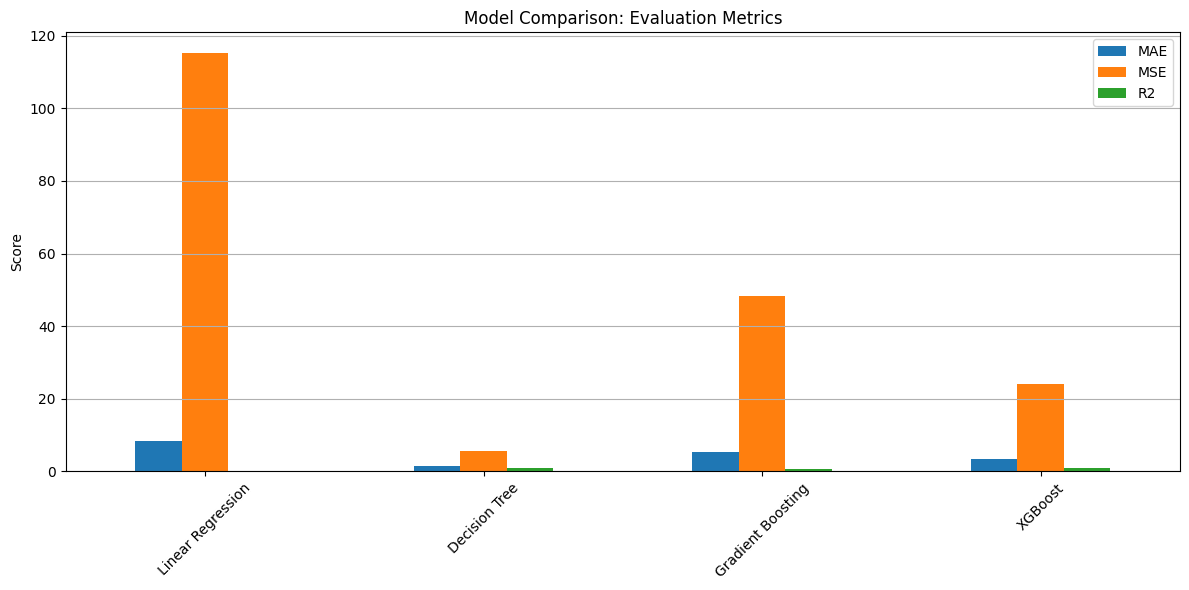

In [ ]:
# Visualizing Model Performance with Residual and Metric Comparison Plots
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "Residuals": y_test - y_pred
    }

# Bar Plot of Evaluation Metrics
metrics_df = pd.DataFrame({model: {
    'MAE': res['MAE'],
    'MSE': res['MSE'],
    'R2': res['R2']
} for model, res in results.items()}).T

metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title("Model Comparison: Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

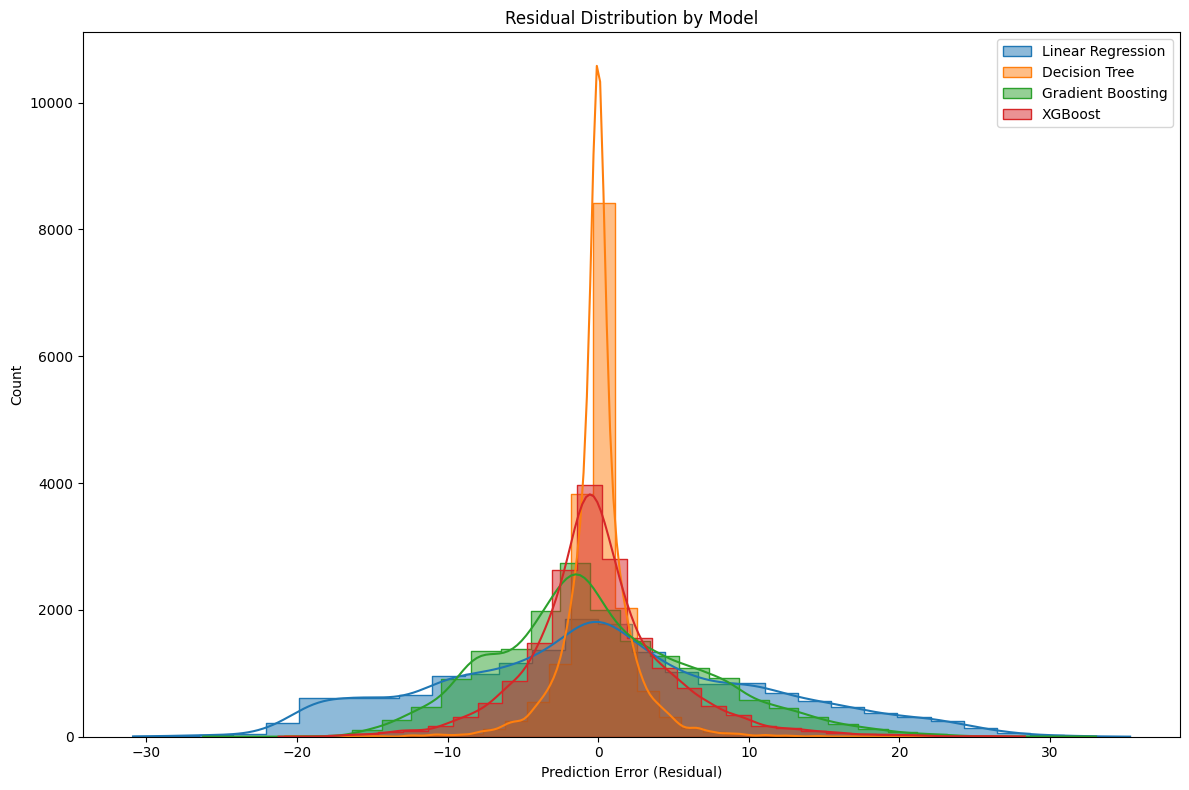

In [ ]:
# Residual Plot for Each Model
plt.figure(figsize=(12, 8))
for name, res in results.items():
    sns.histplot(res['Residuals'], label=name, kde=True, bins=30, element="step")

plt.title("Residual Distribution by Model")
plt.xlabel("Prediction Error (Residual)")
plt.legend()
plt.tight_layout()
plt.show()

# **Key Insights and Recommendations**

**Insights**
1. **Decision Tree Regressor** performed the best (**R² = 0.96, MAE ≈ 1.40**), suggesting it effectively captures the non-linear patterns in energy consumption.
2. **XGBoost Regressor** also showed strong performance (**R² = 0.84, MAE ≈ 3.45**), making it a reliable and generalizable alternative.
3. **Linear Regression** underperformed (**R² = 0.25**), indicating that the energy relationships are not well-modeled linearly.
4. **Gradient Boosting** was moderately effective (**R² = 0.69**), but less so than XGBoost.
5. Outlier removal and time feature extraction likely contributed to the significant performance improvement of the tree-based model.


**Suggestions for Further Improvement**
- Performing hyperparameter tuning using GridSearchCV, especially for the XGBoost and Decision Tree models.
- Incorporating additional temporal features like day of week or weekend flag may improve the performance of the models.
- Feature engineering with domain knowledge, e.g., weather, user traffic behavior.